In [307]:
import os
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from PIL import Image
import numpy as np
import datasets

# Define paths
image_folder = "/Users/norbujamling/Desktop/LhasaGanjur2/Test_Images"
hf_dataset_name = "ta4tsering/Lhasa_kanjur_transcription_datasets"

In [309]:
# Load Hugging Face dataset
hf_dataset = datasets.load_dataset(hf_dataset_name, split="test")

In [311]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert("L")  # Convert to black and white
    image = np.array(image) / 255.0  # Normalize
    return image

In [313]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("openpecha/tibetan_RoBERTa_S_e6")
model = TFAutoModel.from_pretrained("openpecha/tibetan_RoBERTa_S_e6")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [317]:
def transcription_to_vector(transcription):
    tokens = tokenizer(transcription, return_tensors="tf", padding="max_length", max_length=512, truncation=True)
    inputs = {
        "input_ids": tokens["input_ids"],
        "attention_mask": tokens["attention_mask"]
    }
    outputs = model(**inputs)
    vector = outputs.pooler_output  # Extract the pooled output as the vector representation
    return vector

In [325]:
from tqdm import tqdm

def create_dataset(image_folder, hf_dataset):
    # Filter HF dataset to include only transcriptions corresponding to images on your computer
    image_names = [filename.split(".")[0] for filename in os.listdir(image_folder) if not filename.startswith(".")]
    hf_subset = [data for data in hf_dataset if data["filename"].split(".")[0] in image_names]
    
    # Load images and preprocess them
    images = []
    for filename in tqdm(os.listdir(image_folder), desc="Loading images", unit="image"):
        if not filename.startswith("."):  # Exclude hidden files like .DS_Store
            image_path = os.path.join(image_folder, filename)
            image = preprocess_image(image_path)
            images.append(image)
    
    # Load and tokenize transcriptions
    transcriptions = [data["label"] for data in hf_subset]
    vectors = [transcription_to_vector(transcription) for transcription in tqdm(transcriptions, desc="Processing transcriptions", unit="transcription")]
    
    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((images, vectors))
    return dataset

dataset = create_dataset(image_folder, hf_dataset)


Loading images: 100%|█████████| 1001/1001 [00:00<00:00, 1713.05image/s]

Processing transcriptions:   0%|   | 0/1000 [00:00<?, ?transcription/s]
Processing transcriptions:   0%| | 1/1000 [00:00<09:34,  1.74transcript
Processing transcriptions:   0%| | 2/1000 [00:01<11:39,  1.43transcript
Processing transcriptions:   0%| | 3/1000 [00:02<11:44,  1.41transcript
Processing transcriptions:   0%| | 4/1000 [00:02<12:46,  1.30transcript
Processing transcriptions:   0%| | 5/1000 [00:03<12:45,  1.30transcript
Processing transcriptions:   1%| | 6/1000 [00:04<13:10,  1.26transcript
Processing transcriptions:   1%| | 7/1000 [00:05<13:32,  1.22transcript
Processing transcriptions:   1%| | 8/1000 [00:06<13:00,  1.27transcript
Processing transcriptions:   1%| | 9/1000 [00:06<11:51,  1.39transcript
Processing transcriptions:   1%| | 10/1000 [00:07<10:14,  1.61transcrip
Processing transcriptions:   1%| | 11/1000 [00:07<09:12,  1.79transcrip
Processing transcriptions:   1%| | 12/1000 [00:07<08:29,  1.94

In [418]:
# Iterate over the dataset and check the shape of the elements
for image, vector in dataset.take(1):  # Take one batch from the dataset
    print("Image shape:", image.shape)
    print("Transcription vector shape:", vector.shape)

Image shape: (30, 700)
Transcription vector shape: (1, 768)


2024-06-14 11:59:36.187594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


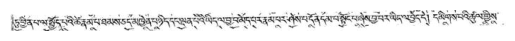

2024-06-14 11:59:36.456338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [420]:
import matplotlib.pyplot as plt

# Take one image from the dataset
for image, _ in dataset.take(1):
    # Plot the image
    plt.imshow(image.numpy(), cmap="gray")
    plt.axis("off")
    plt.show()

In [422]:
# Take one element from the dataset
for image, vector in dataset.take(1):
    # Print the data types
    print("Image data type:", image.dtype)
    print("Transcription vector data type:", vector.dtype)

Image data type: <dtype: 'float64'>
Transcription vector data type: <dtype: 'float32'>


2024-06-14 11:59:36.683852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [424]:
# Check the type of the dataset
print(type(dataset))

<class 'tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset'>


In [426]:
# Apply batching, caching, and prefetching to the dataset

tf_dataset=dataset

tf_dataset = tf_dataset.cache()  # Cache the dataset elements in memory
tf_dataset = tf_dataset.prefetch(tf.data.AUTOTUNE)  # Prefetch data for optimal performance

In [428]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Define the generator model
def build_generator(vector_dim, noise_dim, img_shape):
    input_vector = layers.Input(shape=(vector_dim,))
    input_noise = layers.Input(shape=(noise_dim,))
    
    # Concatenate vector and noise inputs
    x = layers.Concatenate()([input_vector, input_noise])
    
    # Dense layer
    x = layers.Dense(15*350, activation='relu')(x)

    #reshape
    x = layers.Reshape((15,350,1))(x)
    
    #conv layer
    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(32, (5, 5), strides=(1, 1), padding='same', activation='relu')(x)

    #output layer
    output_img = layers.Conv2D(1, (5, 5), activation='tanh', padding='same')(x)
    
    return Model(inputs=[input_vector, input_noise], outputs=output_img)

# Define the discriminator model
def build_discriminator(vector_dim, img_shape):
    input_vector = layers.Input(shape=(vector_dim,))
    input_img = layers.Input(shape=img_shape)
    reshaped_img = layers.Reshape((img_shape[0], img_shape[1], 1))(input_img)
    # Convolutional layers
    x = layers.Conv2D(32, (5, 5), strides=(2, 2), padding='valid', activation='relu')(reshaped_img)
    x = layers.Conv2D(16, (5, 5), strides=(3, 3), padding='valid', activation='relu')(x)
    
    # Flatten
    x = layers.Flatten()(x)
    
    # Concatenate with vector input
    x = layers.Concatenate()([x, input_vector])
    
    # Dense layer
    x = layers.Dense(128, activation='relu')(x)
    
    # Output layer
    output = layers.Dense(1, activation='sigmoid')(x)
    
    return Model(inputs=[input_vector, input_img], outputs=output)

# Define the dimensions
vector_dim = 768  # Dimensionality of the transcription vectors
noise_dim = 100  # Dimensionality of the noise input
img_shape = (30, 700)  # Shape of the generated image

# Build the generator and discriminator models
generator = build_generator(vector_dim, noise_dim, img_shape)
discriminator = build_discriminator(vector_dim, img_shape)

# Print model summaries
print("Generator summary:")
generator.summary()
print("\nDiscriminator summary:")
discriminator.summary()


Generator summary:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 868)       │          0 │ input_layer_4[0]… │
│ (Concatenate)       │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 5250)      │  4,562,250 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 15, 350,   │          0 │ dense_15[0][0]    │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 30, 700,   │      1,664 │ reshape_2[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 30, 700,   │     51,232 │ conv2d_transpose… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 30, 700,   │        801 │ conv2d_transpose… │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,615,947 (17.61 MB)

 Trainable params: 4,615,947 (17.61 MB)

 Non-trainable params: 0 (0.00 B)


Discriminator summary:


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 30, 700)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 30, 700,   │          0 │ input_layer_7[0]… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 13, 348,   │        832 │ reshape_3[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 3, 115,    │     12,816 │ conv2d_4[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 5520)      │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 6288)      │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 128)       │    804,992 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │        129 │ dense_16[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 818,769 (3.12 MB)

 Trainable params: 818,769 (3.12 MB)

 Non-trainable params: 0 (0.00 B)

In [430]:
# Define the loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy()

# Define the discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Define the generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Define the optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [432]:
# Define the batch size
batch_size = 32

In [434]:
# Define the training function
@tf.function
def train_step(images, vectors):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([vectors, noise], training=True)

        real_output = discriminator([vectors, images], training=True)
        fake_output = discriminator([vectors, generated_images], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [436]:
# Define the training loop
def train(dataset, epochs):
    total_batches = len(dataset)
    for epoch in tqdm(range(epochs)):
        # Initialize tqdm progress bar
        progress_bar = tqdm(total=total_batches, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch')
        for image_batch, vector_batch in dataset:
            train_step(image_batch, vector_batch)
            progress_bar.update(1)
        progress_bar.close()

In [438]:
import tensorflow as tf

# Iterate over the dataset and print dimensions of vectors and images
for images, vectors in tf_dataset:
    print("Image shape:", images.shape)
    print("Vector shape:", vectors.shape)


Image shape: (30, 700)
Vector shape: (1, 768)
Image shape: (30, 700)
Vector shape: (1, 768)
Image shape: (30, 700)
Vector shape: (1, 768)
Image shape: (30, 700)
Vector shape: (1, 768)
Image shape: (30, 700)
Vector shape: (1, 768)
Image shape: (30, 700)
Vector shape: (1, 768)
Image shape: (30, 700)
Vector shape: (1, 768)
Image shape: (30, 700)
Vector shape: (1, 768)
Image shape: (30, 700)
Vector shape: (1, 768)
Image shape: (30, 700)
Vector shape: (1, 768)
Image shape: (30, 700)
Vector shape: (1, 768)
Image shape: (30, 700)
Vector shape: (1, 768)
Image shape: (30, 700)
Vector shape: (1, 768)
Image shape: (30, 700)
Vector shape: (1, 768)
Image shape: (30, 700)
Vector shape: (1, 768)
Image shape: (30, 700)
Vector shape: (1, 768)
Image shape: (30, 700)
Vector shape: (1, 768)
Image shape: (30, 700)
Vector shape: (1, 768)
Image shape: (30, 700)
Vector shape: (1, 768)
Image shape: (30, 700)
Vector shape: (1, 768)
Image shape: (30, 700)
Vector shape: (1, 768)
Image shape: (30, 700)
Vector shap

2024-06-14 11:59:39.601453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [440]:
mydataset=tf_dataset.batch(batch_size, drop_remainder=True)

In [442]:
def reshape_image(image, label):
    # Remove the singleton dimension
    label_reshaped = tf.squeeze(label, axis=1)
    return image, label_reshaped

# Apply the reshape_image function to the dataset
mydataset = mydataset.map(reshape_image)

In [444]:
# Iterate over the dataset and print dimensions of vectors and images
for i,j in mydataset:
    print("Image shape:", i.shape)
    print("Image shape:", j.shape)
    


Image shape: (32, 30, 700)
Image shape: (32, 768)
Image shape: (32, 30, 700)
Image shape: (32, 768)
Image shape: (32, 30, 700)
Image shape: (32, 768)
Image shape: (32, 30, 700)
Image shape: (32, 768)
Image shape: (32, 30, 700)
Image shape: (32, 768)
Image shape: (32, 30, 700)
Image shape: (32, 768)
Image shape: (32, 30, 700)
Image shape: (32, 768)
Image shape: (32, 30, 700)
Image shape: (32, 768)
Image shape: (32, 30, 700)
Image shape: (32, 768)
Image shape: (32, 30, 700)
Image shape: (32, 768)
Image shape: (32, 30, 700)
Image shape: (32, 768)
Image shape: (32, 30, 700)
Image shape: (32, 768)
Image shape: (32, 30, 700)
Image shape: (32, 768)
Image shape: (32, 30, 700)
Image shape: (32, 768)
Image shape: (32, 30, 700)
Image shape: (32, 768)
Image shape: (32, 30, 700)
Image shape: (32, 768)
Image shape: (32, 30, 700)
Image shape: (32, 768)
Image shape: (32, 30, 700)
Image shape: (32, 768)
Image shape: (32, 30, 700)
Image shape: (32, 768)
Image shape: (32, 30, 700)
Image shape: (32, 768)


2024-06-14 11:59:40.730996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# Train the CGAN
train(mydataset, epochs=100)

  0%|                                          | 0/100 [00:00<?, ?it/s]



Epoch 1/100:   0%|                           | 0/31 [00:00<?, ?batch/s]



Epoch 1/100:   3%|▌                  | 1/31 [00:01<00:32,  1.09s/batch]



Epoch 1/100:   6%|█▏                 | 2/31 [00:02<00:29,  1.02s/batch]



Epoch 1/100:  10%|█▊                 | 3/31 [00:03<00:28,  1.01s/batch]



Epoch 1/100:  13%|██▍                | 4/31 [00:04<00:27,  1.00s/batch]



Epoch 1/100:  16%|███                | 5/31 [00:04<00:25,  1.02batch/s]



Epoch 1/100:  19%|███▋               | 6/31 [00:05<00:24,  1.04batch/s]



Epoch 1/100:  23%|████▎              | 7/31 [00:06<00:22,  1.06batch/s]



Epoch 1/100:  26%|████▉              | 8/31 [00:07<00:21,  1.06batch/s]



Epoch 1/100:  29%|█████▌             | 9/31 [00:08<00:20,  1.07batch/s]



Epoch 1/100:  32%|█████▊            | 10/31 [00:09<00:19,  1.07batch/s]



Epoch 1/100:  35%|██████▍           | 11/31 [00:10<00:18,  1.07batch/s]



Epoch 1/100:  39%|██████▉

In [507]:
import tensorflow as tf
from transformers import AutoTokenizer, AutoModel

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("openpecha/tibetan_RoBERTa_S_e6")
model = AutoModel.from_pretrained("openpecha/tibetan_RoBERTa_S_e6")

# Define the Tibetan text
tibetan_text = "ཀྱང་ཤེས་རབ་ཀྱི་ཕ་རོལ་ཏུ་ཕྱིན་པ་མ་ཡིན། བྱང་ཆུབ་ཀྱི་ཡན་ལག་རྣམས་ཀྱི་དེ་བཞིན་ཉིད་ལས་གུད་ནའང་ཤེས་རབ་ཀྱི་ཕ་རོལ་ཏུ་ཕྱིན་པ་མེད་དོ། །བྱང་ཆུབ་ཀྱི་ཡན་ལག་རྣམས་"

# Tokenize the text
tokens = tokenizer(tibetan_text, return_tensors="pt")

# Pass the tokens through the model to get the embeddings
with tf.device('/CPU:0'):
    outputs = model(**tokens)

# Get the embeddings
embeddings = outputs.last_hidden_state

# Convert embeddings to a numpy array

# Assuming word_vector is the tensor you want to convert
# Detach the tensor from the computation graph
word_vector_detached = embeddings.detach()

# Convert the detached tensor to a NumPy array
tibetan_vector = word_vector_detached.numpy()


Some weights of RobertaModel were not initialized from the model checkpoint at openpecha/tibetan_RoBERTa_S_e6 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


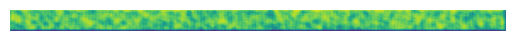

In [508]:
import tensorflow as tf
import numpy as np

# Normalize the Tibetan vector
normalized_tibetan_vector = tf.keras.utils.normalize(tf.reduce_mean(tibetan_vector, axis=1))

# Define the noise dimension
noise_dim = 100

# Generate random noise
noise = tf.random.normal([1, noise_dim])

# Concatenate the Tibetan vector and noise
input_data = [normalized_tibetan_vector, noise]

# Generate an image using the generator
generated_image = generator(input_data, training=False)

# Rescale the pixel values from [-1, 1] to [0, 1]
generated_image = (generated_image + 1) / 2

# Visualize the generated image
import matplotlib.pyplot as plt
plt.imshow(generated_image[0])
plt.axis('off')
plt.show()
